In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
import matplotlib.pyplot as plt

# Chem 277B : HW4 - Regression #

## 1. Linear regression using a simple perceptron ##

For getting into graduate school, download the grad school attribute data set from Files. 

In [2]:
data=pd.read_csv("Admission_Predict_Ver1.1.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


**(a)** Define the features that are related to predicting the Chance of Admit, and normalize them.

GRE Score, TOEFL Score, University Ranking, Statement of Purpose, Letters of Recommendation, CGPA, Research are all the features related to predicting the Chance of Admit.

In [3]:
from sklearn.preprocessing import StandardScaler

academic_features = data.drop(['Serial No.', 'Chance of Admit '], axis=1).values
chance_of_admit = data['Chance of Admit '].values

scaler = StandardScaler()
academic_feats_norm = scaler.fit_transform(academic_features)

**(b)** Fill in the code for a simple perceptron. Initialize your weights and biases between 0 and 0.05
using your random number generator. Use the mean squares error (MSE) to adjust your weights through
back-propagation. Fill in the blanks for the feedforward and backpropagation step.

In [4]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### Initialize parameters ###
        self.weights = np.random.random((input_dim, output_dim)) * 0.05
        self.bias = np.random.random(output_dim) * 0.05

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((-1, 1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        # Calculate logit and activation
        self.z = np.dot(X, self.weights) + self.bias  #shape(X.shape[0],1)
        self.a = self.activation(self.z)              #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((-1, 1))
        if len(y.shape)==1:
            y=y.reshape((-1, 1))
        self.predict(X)
        errors = (self.a - y)*self.activation_grad(self.z)  # shape: (X.shape[0], 1)
        weights_grads = errors.T.dot(X)
        bias_grad = errors.sum(axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -= self.lr * weights_grads.T
        self.bias -= self.lr * bias_grad

    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        np.random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])

    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean((self.predict(X)-y)**2)
    
    def get_weights(self):
        return (self.weights,self.bias)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.bias=weights[1]

**(c)** Fill in the code for k-fold validation. Use 80% of the data for training and 20% of the data for
testing and do 5-fold validation. Use a learning rate of 0.0001. Are the features good indicators for getting
into graduate school?

In [5]:
from sklearn.model_selection import train_test_split,KFold


def Kfold(k,Xs,ys,epochs,learning_rate=0.0001, draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        train_ys=ys[train_selector]
        test_Xs=Xs[test_selector]
        test_ys=ys[test_selector]
        print(f"train Xs size: {train_Xs.shape} \t test Xs size: {test_Xs.shape}")

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, test_size=0.2)
        
        ### Establish the model for simple perceptron here ###
        # Check dimension of input and output
        if Xs.ndim == 1:
            Xs = Xs.reshape((-1, 1))
        if ys.ndim == 1:
            ys = ys.reshape((-1, 1))
        model = simple_perceptron(Xs.shape[1], ys.shape[1], learning_rate=learning_rate)

        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs   
        final_epochs = np.argmin(val_array)+1
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the best model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error = model.evaluate(train_Xs,train_ys)
        train_error_all.append(train_error)
        test_error = model.evaluate(test_Xs,test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        # Draw the curve of error in validation set
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Validation Loss for Fold %d'%len(train_error_all))
            plt.show()

    # Report the average error for all folds
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))

    # return the last model
    return model

train Xs size: (400, 7) 	 test Xs size: (100, 7)
Number of epochs with lowest validation: 190
Train error: 0.03639524032367629
Test error: 0.03726463062369767


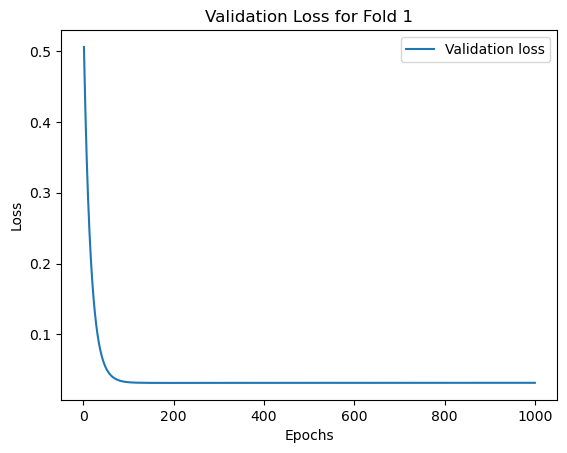

train Xs size: (400, 7) 	 test Xs size: (100, 7)
Number of epochs with lowest validation: 979
Train error: 0.0035363471267877587
Test error: 0.0037220081397410566


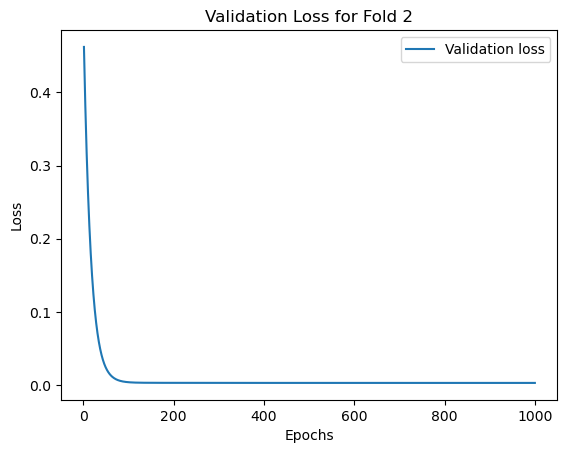

train Xs size: (400, 7) 	 test Xs size: (100, 7)
Number of epochs with lowest validation: 932
Train error: 0.0032414319817119703
Test error: 0.005227173311513322


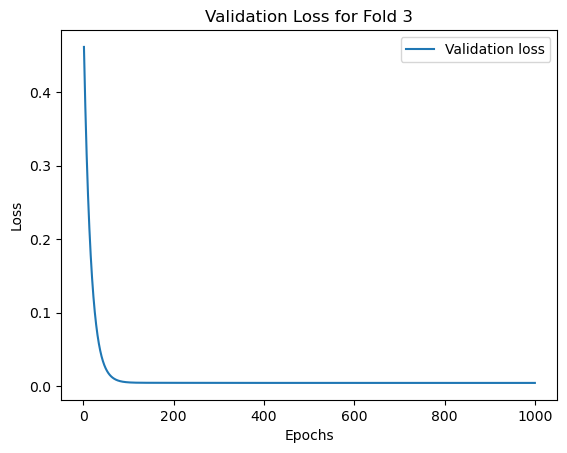

train Xs size: (400, 7) 	 test Xs size: (100, 7)
Number of epochs with lowest validation: 967
Train error: 0.0037727892115846347
Test error: 0.0027143675058345722


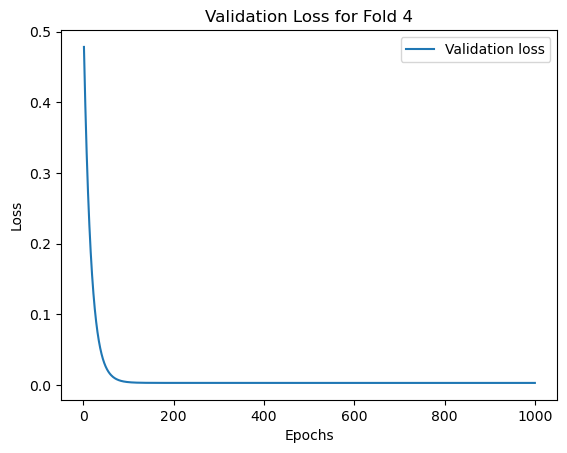

train Xs size: (400, 7) 	 test Xs size: (100, 7)
Number of epochs with lowest validation: 218
Train error: 0.00361014426204206
Test error: 0.0033611664121304193


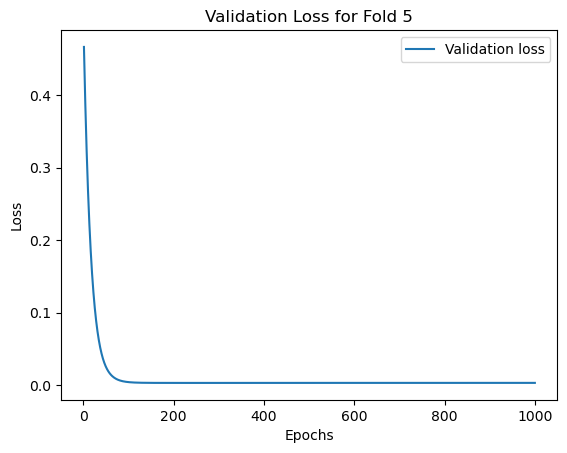

Final results:
Training error:0.010111+-0.013143
Testing error:0.010458+-0.013429


(array([[0.01841859],
        [0.01870715],
        [0.00426147],
        [0.00209506],
        [0.01456039],
        [0.07746257],
        [0.01172945]]),
 array([0.71971874]))

In [6]:
all_features = Kfold(5, academic_feats_norm, chance_of_admit, 1000, learning_rate=0.0001)
all_features.get_weights()

Now remove the GRE scores and do the same test; are GRE scores important?

train Xs size: (400, 6) 	 test Xs size: (100, 6)
Number of epochs with lowest validation: 189
Train error: 0.034448150758426964
Test error: 0.039062968103464116


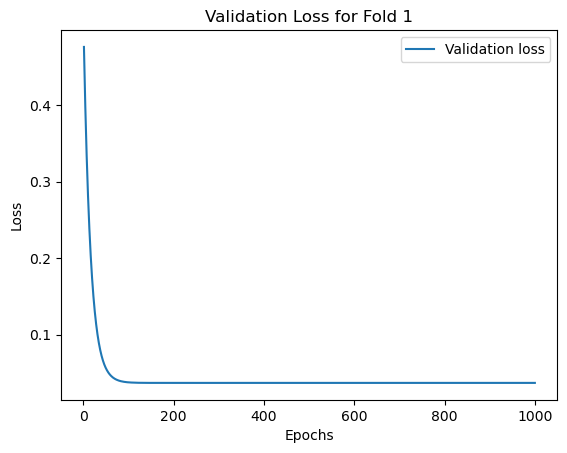

train Xs size: (400, 6) 	 test Xs size: (100, 6)
Number of epochs with lowest validation: 151
Train error: 0.0037323188124698346
Test error: 0.003531404959063698


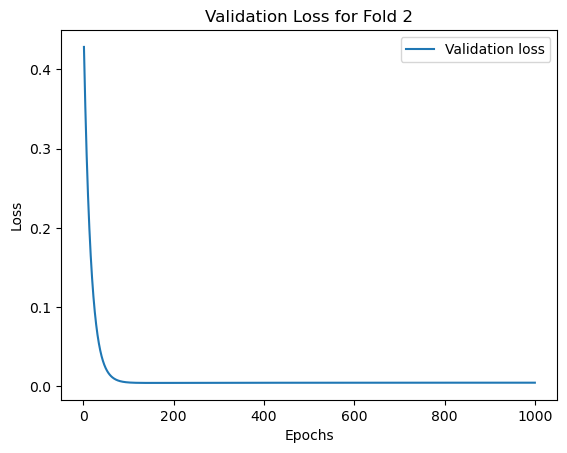

train Xs size: (400, 6) 	 test Xs size: (100, 6)
Number of epochs with lowest validation: 411
Train error: 0.0038498460542025297
Test error: 0.0029650427606178753


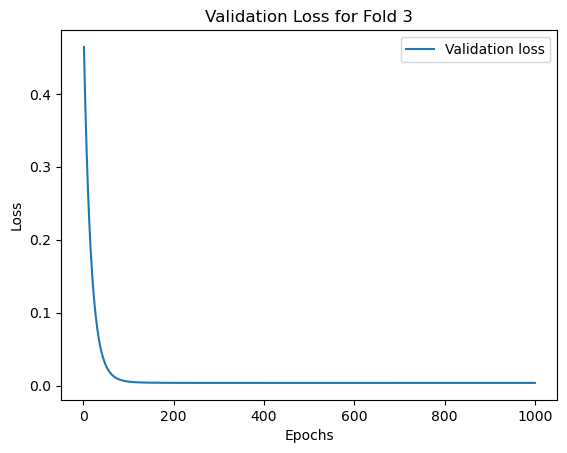

train Xs size: (400, 6) 	 test Xs size: (100, 6)
Number of epochs with lowest validation: 978
Train error: 0.0036802327840876393
Test error: 0.0037097209684626782


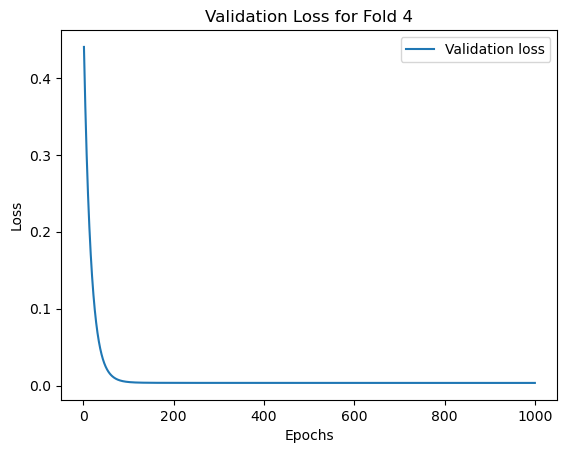

train Xs size: (400, 6) 	 test Xs size: (100, 6)
Number of epochs with lowest validation: 378
Train error: 0.003442811716365263
Test error: 0.0047125064822399225


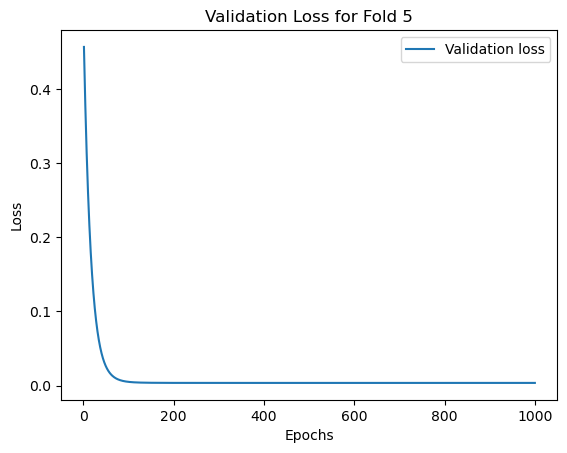

Final results:
Training error:0.009831+-0.012309
Testing error:0.010796+-0.014145


(array([[ 0.03044218],
        [ 0.01036251],
        [-0.00721091],
        [ 0.0132306 ],
        [ 0.0857004 ],
        [ 0.01429045]]),
 array([0.7192629]))

In [8]:
gre_removed = Kfold(5, academic_feats_norm[:,1:], chance_of_admit, 1000, learning_rate=0.0001)
gre_removed.get_weights()

Looking at the error between the two, it does not seem like GRE scores are a very import factor because the error is nearly the same between them. Both of the average training and testing errors are approximately 0.01. In addition, looking at the final adjusted weights of the model, the weight for GRE scores (0.17) is relatively low compared to the weight for CGPA (0.74). Therefore, the chance of admission is still greatly predictable without GRE scores.

## 2. Logistic regression using a simple perceptron. ##

For whether your status is sufficient to make it 
off the Titanic, download the Titanic data set from Files.  

**(a)** Process the dataset. What changes from problem 1? Filter out data with missing features. Use one-
hot encoders to transform the categorical features and the output survival status. 

In [9]:
# read in dataset
titanic_data = pd.read_csv('titanic.csv')

# drop rows with missing values
titanic_data = titanic_data.dropna()
# drop categorical features
titanic_numeric_feats = titanic_data.drop(columns=['PassengerId', 'Survived', 'Pclass', 'Name', 
                                                   'Sex', 'Ticket', 'Cabin', 'Embarked'])
# normalize the numeric features
titanic_feats_norm = scaler.fit_transform(titanic_numeric_feats)

# get categorical features
titanic_cate_feats = titanic_data[['Pclass', 'Sex', 'Embarked']]
titanic_cate_feats['Cabin'] = titanic_data['Cabin'].str[0]

# one-hot encode the categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder() 
input_cate_feats = encoder.fit_transform(titanic_cate_feats).toarray()

# combine the numeric and categorical features
titanic_feats = np.hstack((titanic_feats_norm, input_cate_feats))

# get survival information 
output_encoder = OneHotEncoder()
y = np.array(titanic_data['Survived']).reshape(-1, 1)
survived_y = output_encoder.fit_transform(y).toarray()

In this dataset, there is a lot more unneeded data as well as data with NA values compared to the dataset in problem 1. In addition, because there is categorical data in the Titanic dataset, we use one-hot encoding to convert these data to be understood by the model.
<br>
<br>

**(b)** Use the simple perceptome model we developed in Q1. Use 80% of the data for training and 20% 
of  the  data  for  testing  and  do  5-fold  validation.  Can  we  predict  who  will  survive?  Play  around  with  the 
features to determine which ones give you a better chance to get back to shore. 

train Xs size: (146, 20) 	 test Xs size: (37, 20)
Number of epochs with lowest validation: 1000
Train error: 0.1417033214520892
Test error: 0.14474042361601663


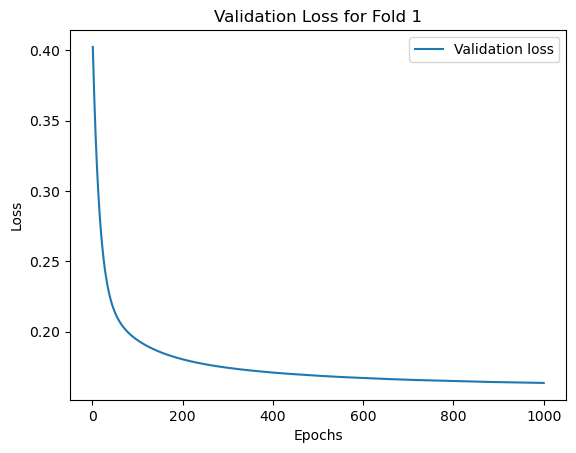

train Xs size: (146, 20) 	 test Xs size: (37, 20)
Number of epochs with lowest validation: 1000
Train error: 0.13966774821713918
Test error: 0.15664876989829873


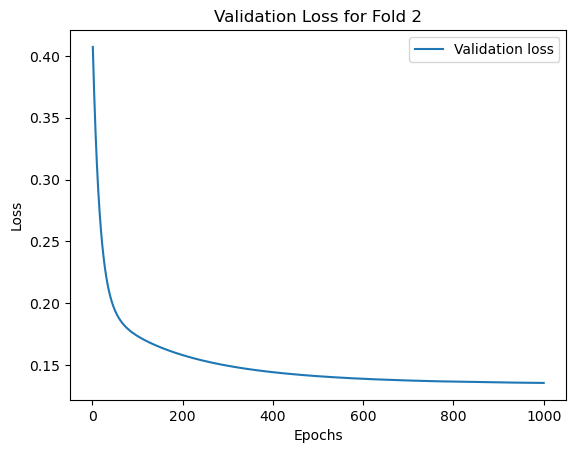

train Xs size: (146, 20) 	 test Xs size: (37, 20)
Number of epochs with lowest validation: 516
Train error: 0.1262743224841775
Test error: 0.2148049783447163


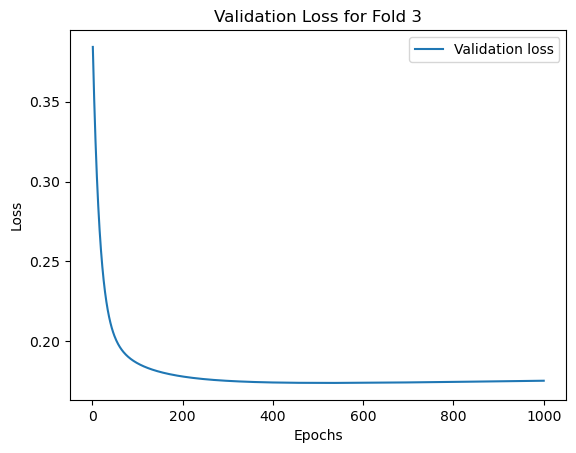

train Xs size: (147, 20) 	 test Xs size: (36, 20)
Number of epochs with lowest validation: 513
Train error: 0.14645761258261852
Test error: 0.11816062159731135


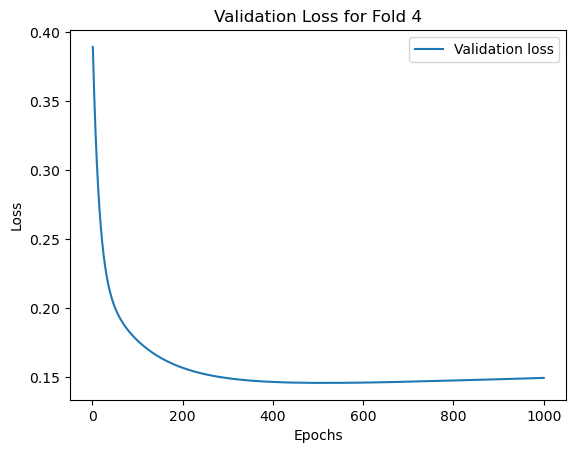

train Xs size: (147, 20) 	 test Xs size: (36, 20)
Number of epochs with lowest validation: 700
Train error: 0.13996438378000217
Test error: 0.16361110183315863


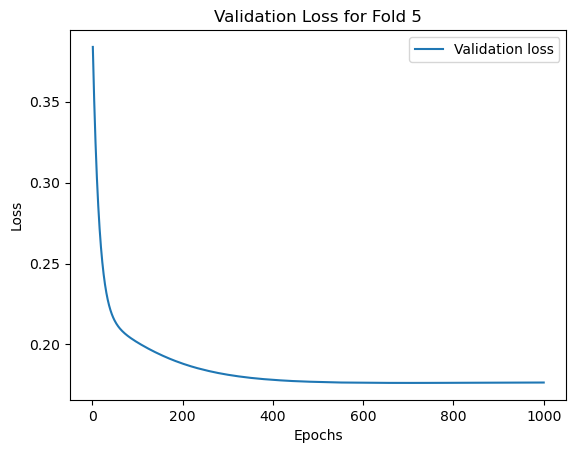

Final results:
Training error:0.138813+-0.006724
Testing error:0.159593+-0.031656


In [27]:
titanic_prediction = Kfold(5, titanic_feats, survived_y, 1000, learning_rate=0.0001)

In [11]:
output_encoder.inverse_transform(titanic_prediction.predict(titanic_feats))

array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
    

The model can predict who survives with approximately 0.15 error. 

train Xs size: (146, 3) 	 test Xs size: (37, 3)
Number of epochs with lowest validation: 823
Train error: 0.20897669286729667
Test error: 0.2564102804605369


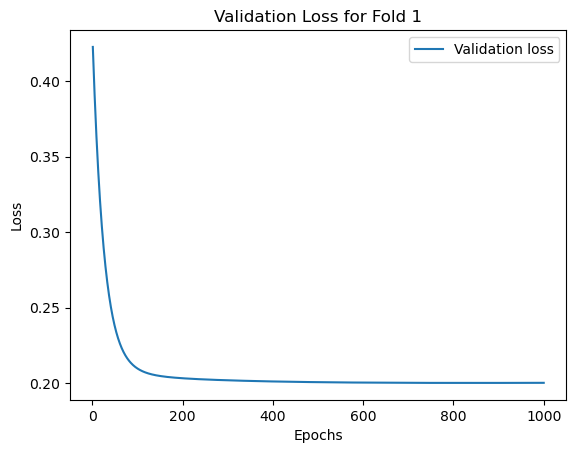

train Xs size: (146, 3) 	 test Xs size: (37, 3)
Number of epochs with lowest validation: 1000
Train error: 0.22601768437030784
Test error: 0.19884095326811269


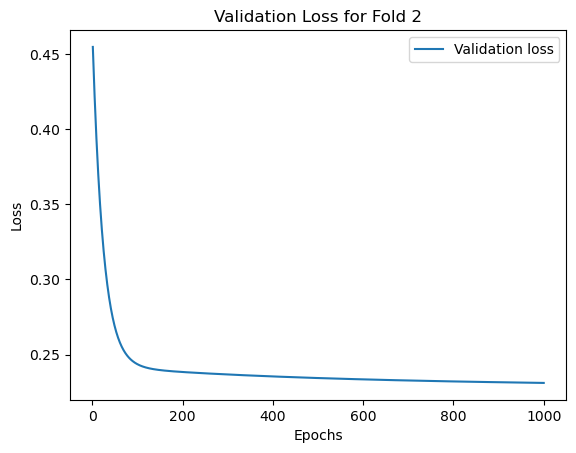

train Xs size: (146, 3) 	 test Xs size: (37, 3)
Number of epochs with lowest validation: 780
Train error: 0.21209734983923306
Test error: 0.24249400402733903


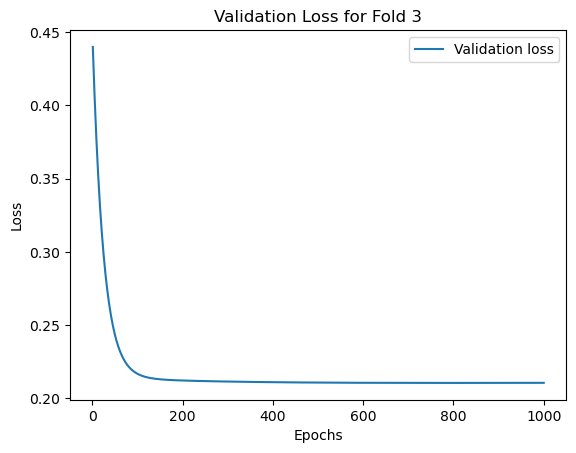

train Xs size: (147, 3) 	 test Xs size: (36, 3)
Number of epochs with lowest validation: 803
Train error: 0.2175778173954432
Test error: 0.22411512959787055


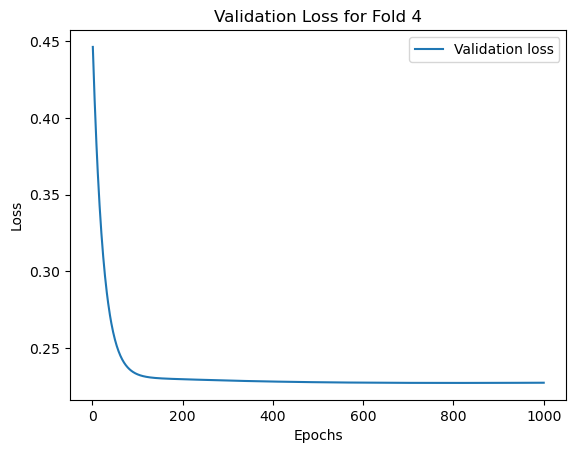

train Xs size: (147, 3) 	 test Xs size: (36, 3)
Number of epochs with lowest validation: 1000
Train error: 0.22122191445172118
Test error: 0.21828182208288915


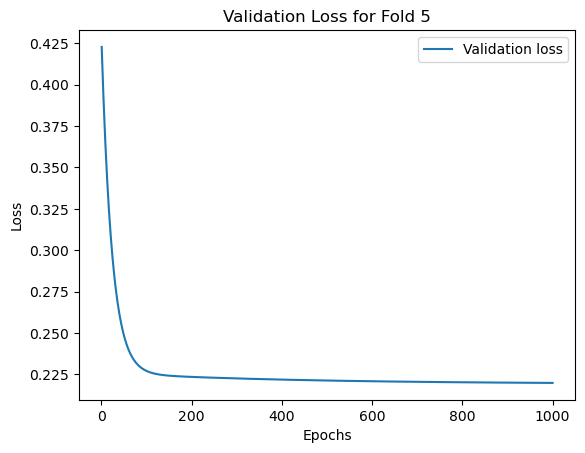

Final results:
Training error:0.217178+-0.006127
Testing error:0.228028+-0.019885


In [12]:
pclass = Kfold(5, titanic_feats[:,4:7], survived_y, 1000, learning_rate=0.0001)

train Xs size: (146, 1) 	 test Xs size: (37, 1)
Number of epochs with lowest validation: 877
Train error: 0.22784777694576047
Test error: 0.20119022401184372


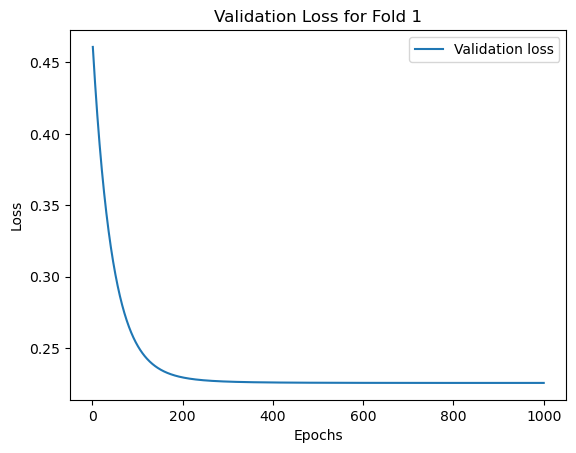

train Xs size: (146, 1) 	 test Xs size: (37, 1)
Number of epochs with lowest validation: 218
Train error: 0.2146357007590374
Test error: 0.22939710083179926


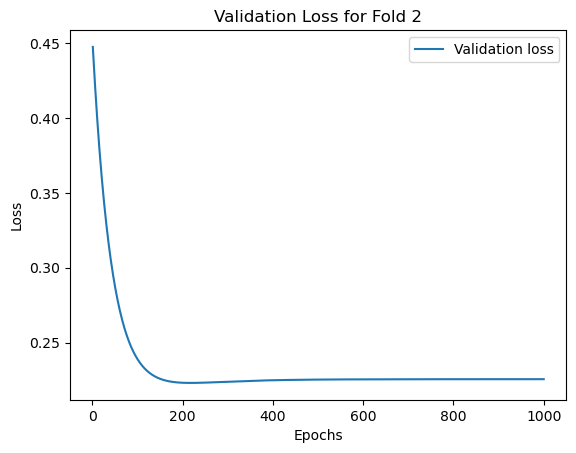

train Xs size: (146, 1) 	 test Xs size: (37, 1)
Number of epochs with lowest validation: 961
Train error: 0.208201190364013
Test error: 0.24943125178076636


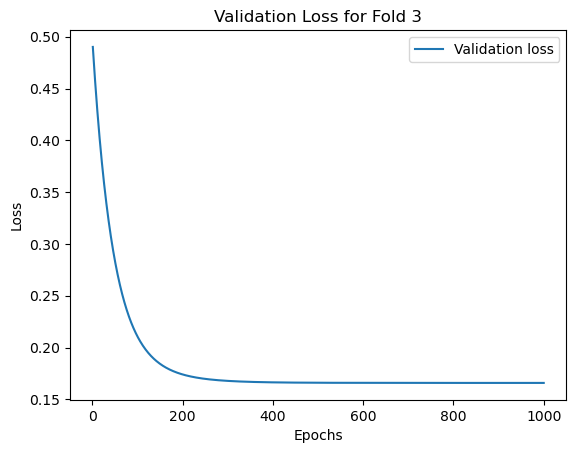

train Xs size: (147, 1) 	 test Xs size: (36, 1)
Number of epochs with lowest validation: 880
Train error: 0.22162564887840575
Test error: 0.20614423283792072


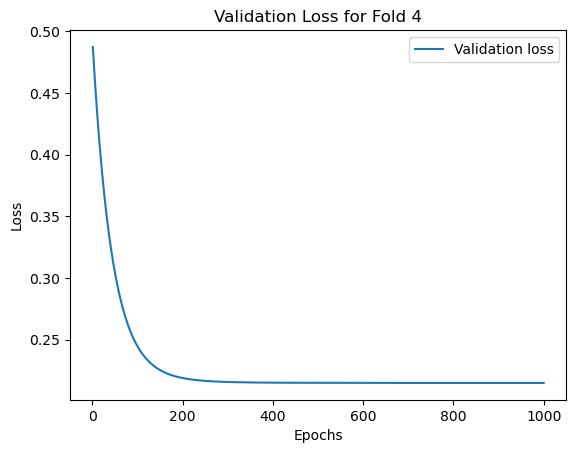

train Xs size: (147, 1) 	 test Xs size: (36, 1)
Number of epochs with lowest validation: 933
Train error: 0.21134846379656655
Test error: 0.2377599760276219


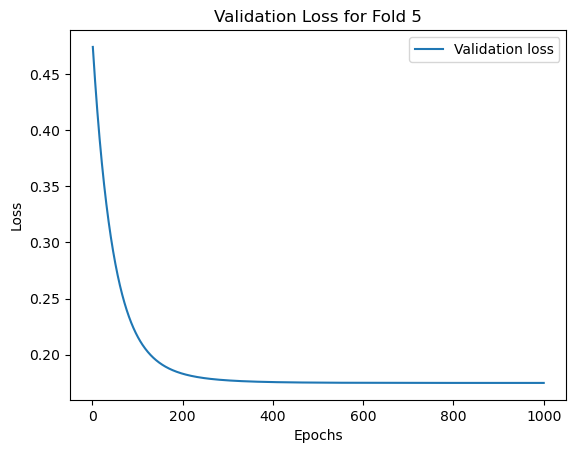

Final results:
Training error:0.216732+-0.007123
Testing error:0.224785+-0.018446


In [13]:
fare = Kfold(5, titanic_feats[:,3].reshape(-1, 1), survived_y, 1000, learning_rate=0.0001)

In [25]:
titanic_prediction.get_weights()

(array([[ 0.09305184, -0.09807535],
        [-0.04727066,  0.04727799],
        [ 0.03528699, -0.03513606],
        [-0.04585308,  0.04177224],
        [ 0.05045182,  0.13640615],
        [-0.05319716,  0.18395145],
        [ 0.13812022, -0.00126651],
        [-0.18105102,  0.38483043],
        [ 0.32642566, -0.12066885],
        [ 0.05037336,  0.13588772],
        [ 0.07457564,  0.00217629],
        [ 0.06269421,  0.12622698],
        [-0.0441299 ,  0.12873379],
        [-0.01283139,  0.10834933],
        [ 0.20758263, -0.10769135],
        [ 0.00653282,  0.09309507],
        [-0.05993136,  0.17188319],
        [ 0.06553435,  0.06046546],
        [ 0.15584473, -0.05290314],
        [ 0.00621079,  0.04213391]]),
 array([0.10601627, 0.22163501]))

Information on the Fare and Passenger Class both are able to be used to predict whether or not a person makes it back to shore. Looking at the weights, row 7 seems to be most influential for whether or not someone survives. This row corresponds to sex, in seems to favor being female. Therefore, perhaps women were more likely to survive than their male counterparts.

## 3. Nonlinear regression using a simple perceptron and a simple ANN. ##

Let’s try to fit to a simple 
sine function y = 3 sin(x) + 5 with the simple perceptron and a simple fully connected network.

**(a)** Use the generate_data() function provided in the reference file to generate the training data (5000 
points). Do 5-fold cross validation with the simple perceptron model. How well is the prediction? Generate 
1000  new  points  as  your  test  data,  and  use  the  show_correlation()  function  to  see  how  well  your  model 
agree with the test data. 

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

train Xs size: (4000, 1) 	 test Xs size: (1000, 1)
Number of epochs with lowest validation: 775
Train error: 4.171032456800576
Test error: 4.247650417690584


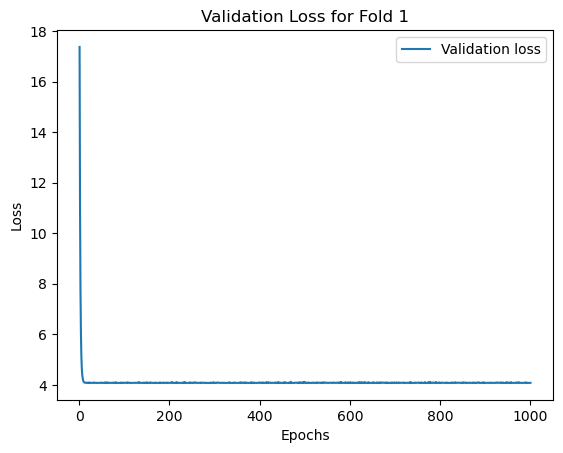

train Xs size: (4000, 1) 	 test Xs size: (1000, 1)
Number of epochs with lowest validation: 11
Train error: 4.1219465743298125
Test error: 4.419847032109861


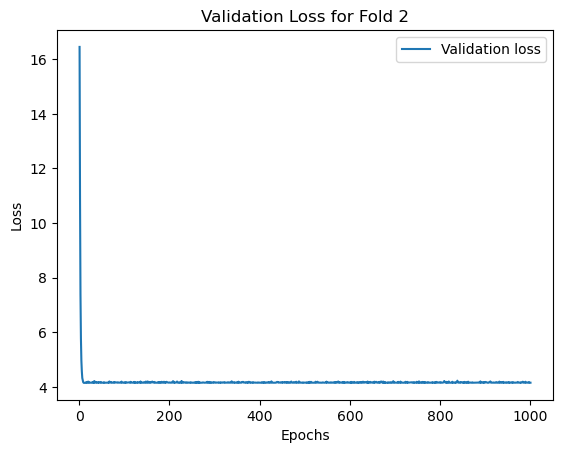

train Xs size: (4000, 1) 	 test Xs size: (1000, 1)
Number of epochs with lowest validation: 502
Train error: 4.1813267380187735
Test error: 4.225271309208258


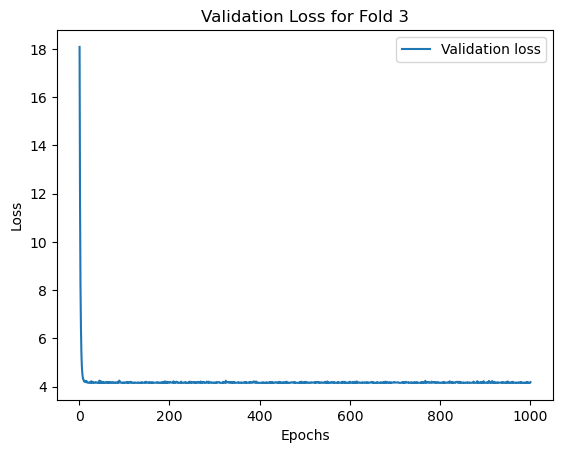

train Xs size: (4000, 1) 	 test Xs size: (1000, 1)
Number of epochs with lowest validation: 927
Train error: 4.25169615710593
Test error: 3.9014959973439236


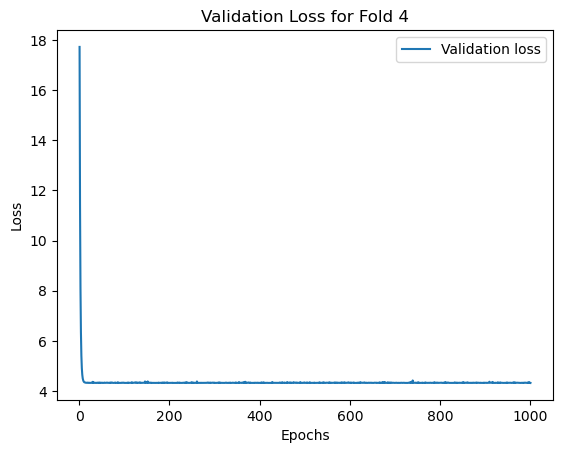

train Xs size: (4000, 1) 	 test Xs size: (1000, 1)
Number of epochs with lowest validation: 232
Train error: 4.20393321107984
Test error: 4.14392251605395


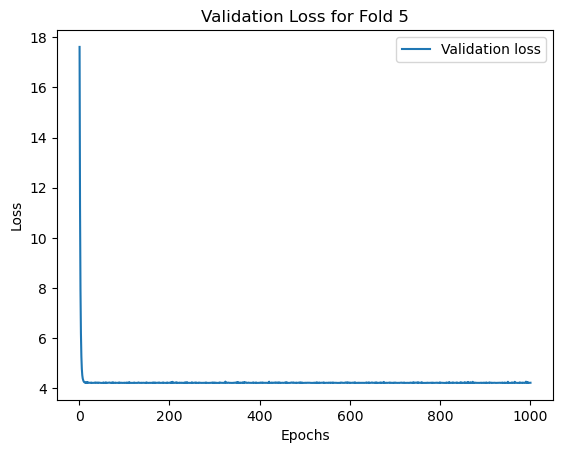

Final results:
Training error:4.185987+-0.042394
Testing error:4.187637+-0.168954


In [15]:
# training data
x_train,y_train=generate_data(5000,0.1)
# test data
x_test,y_test=generate_data(1000,0.1)

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

sine_regression = Kfold(5, x_train, y_train, 1000, learning_rate=0.0001)

In [17]:
sine_regression.predict(x_train)

array([[-5.39554881],
       [-5.47437629],
       [-5.04844966],
       ...,
       [-5.22809088],
       [-5.45685454],
       [-5.37723445]])

It seems like the prediction isn't very accurate. Although the model quickly reduces loss after just about 10 or so epochs, the error for both training and testing data is around 4.19. This is a lot compared to the error of the models created prior to problem 3. 

#### Comparing to test data ###

In [18]:
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[0,1]
    print("Correlation coefficient:",corr)

Correlation coefficient: 0.2046057507236682


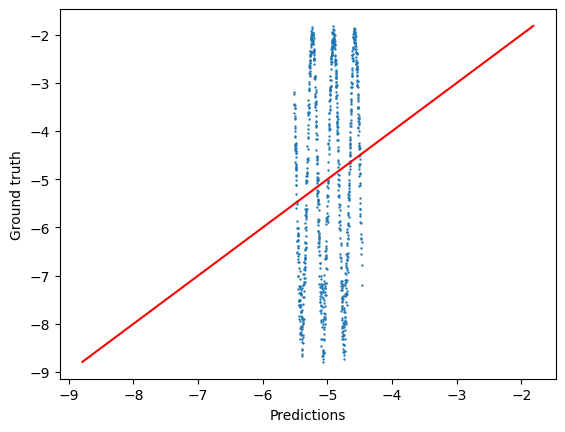

In [19]:
y_test = np.reshape(y_test, (1000,))
show_correlation(np.reshape(sine_regression.predict(x_test), (1000,)), y_test)

Looking at this graph, we see that the predicted do not really match with the ground truth. The correlation coefficient is also quite low (0.20), so we can assume there is not a strong relationship among the data. This model did not do so well.
<br>
<br>

**(b)** Use the multilayer perceptron regressor of scikit-learn as a simple fully connected neural network. 
Use one hidden layer with 8 neurons. Do 5-fold cross validation with this simple ANN, and report the MSE 
on each fold. Visualize the correlation of your model prediction and the true test data.  Is the result better 
than a simple perceptron? 

In [20]:
from sklearn.neural_network import MLPRegressor

def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001,):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        train_Xs=Xs[train_selector]
        train_ys=ys[train_selector]
        test_Xs=Xs[test_selector]
        test_ys=ys[test_selector]
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error= np.mean((model.predict(train_Xs)-train_ys)**2)
        train_error_all.append(train_error)
        test_error= np.mean((model.predict(test_Xs)-test_ys)**2)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

In [21]:
sine_regression_ANN = KFold_NN(5, x_train, y_train.reshape(-1,), (8,), epochs=1000, lr=0.001)

Train error: 4.091071983289639
Test error: 3.9035469171599124
Train error: 2.4093731832010925
Test error: 2.5286842676230643
Train error: 2.4139313811143213
Test error: 2.437670498386772
Train error: 2.4062762390853503
Test error: 2.617128135851991
Train error: 0.994162437690494
Test error: 0.9132818835759434
Final results:
Training error:2.462963+-0.981489
Testing error:2.480062+-0.949111


/Users/joshua/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Correlation coefficient: 0.8839617877277199


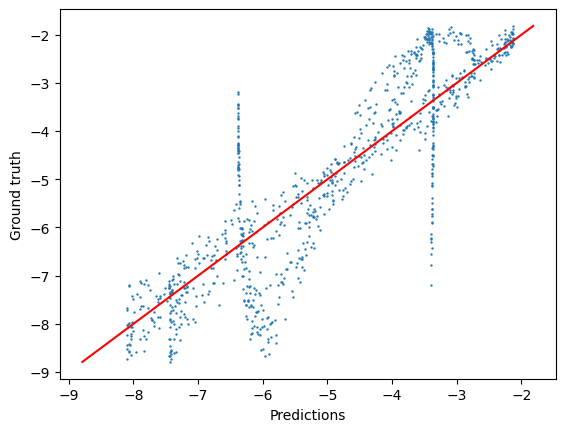

In [22]:
show_correlation(np.reshape(sine_regression_ANN.predict(x_test), (1000,)), y_test)

The result is much better than from using the simple perceptron. With the simple perceptron, the average error over 5 folds was around 4, whereas with the multilayer perceptron regressor, the average error was reduced to 2.5. The correlation coefficient also rose from 0.20 to 0.88. 

**(c)** Play with the architecture for the ANN, can you improve the performance by including additional 
hidden layers? 

In [23]:
sine_regression = KFold_NN(5, x_train, y_train.reshape(-1,), (10,12), epochs=1000, lr=0.001)

Train error: 0.10306120868816467
Test error: 0.10099921369985768
Train error: 0.10231538289785251
Test error: 0.11154435157325963
Train error: 0.10660322836665842
Test error: 0.10588279039551753


/Users/joshua/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.10913384104356785
Test error: 0.1089898215802898
Train error: 0.10617082115013142
Test error: 0.11020977635948052
Final results:
Training error:0.105457+-0.002488
Testing error:0.107525+-0.003763


Correlation coefficient: 0.9876270305921461


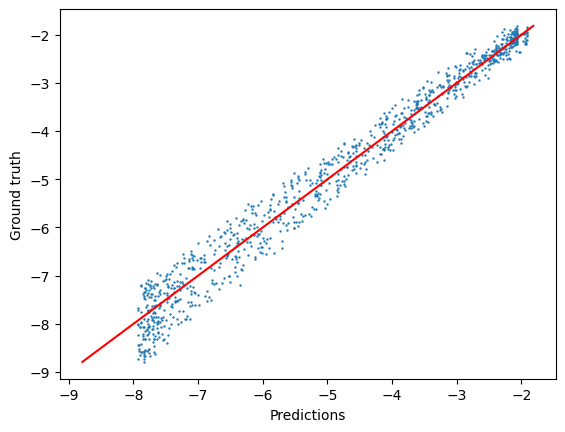

In [24]:
show_correlation(np.reshape(sine_regression.predict(x_test), (1000,)), y_test)

Adding 10 and 12 to the hidden layer improved the model even further, resulting in training and error of approximately 0.11 and a correlation coefficient of approximately 0.99. This is a very good model.